# Inverse fit: recover G(t) step values from measured pdp

Use `permeation.inverse_fit` to fit step values of the incident flux G(t) to measured downstream pressure (pdp). **Zoom fit** (`fit_G_steps_zoom`) starts with one step and refines by doubling the number of steps each level; use `fit_G_steps` for a single-level fit with fixed step times.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import permeation as pm

# Optional: nicer defaults for notebooks
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.figsize"] = (6, 4)

## 1. Define base parameters and "true" G(t) steps

We fix physics (ks, kd, D) and step *start* times; the inverse fit finds the step *values*.

In [2]:
base_params = pm.Parameters()
base_params.ks = 3.3e19
base_params.kd = 1.2e-34
base_params.D = 1e-8

tstart = [0.0, 0.2, 0.4, 0.5]   # step start times (fraction of run)
true_vals = np.array([0.3, 0.7, 0.6, 0.0])  # true step values

# Forward simulate to get "true" pdp
t_true, pdp_true, G_true = pm.simulate_from_step_vals(true_vals, tstart, base_params)

## 2. Synthetic measurements (noisy pdp on same time grid)

In [3]:
rng = np.random.default_rng(0)
t_meas = t_true.copy()
noise = 0.02 * np.max(pdp_true) * rng.normal(size=pdp_true.shape)
pdp_meas = pdp_true + noise

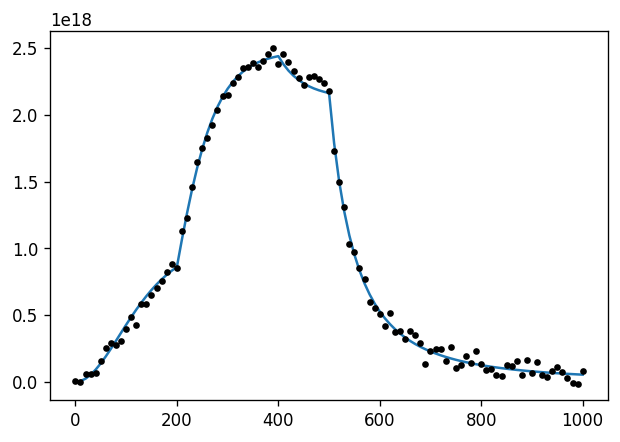

In [4]:
plt.plot(t_true,pdp_true,'-')
plt.plot(t_meas,pdp_meas,'k.')

## 3. Zoom fit: refine from one step to many

`fit_G_steps_zoom` starts with a single step over [0, 1], fits it, then doubles the number of steps each level via `refine_steps` and refits. No need to specify step times in advance.

In [5]:
n_levels = 6
zoom = pm.fit_G_steps_zoom(
    t_meas=t_meas,
    pdp_meas=pdp_meas,
    base_params=base_params,
    initial_guess=0.5,
    n_levels=n_levels,
    bounds=(0.0, 2.0),
    reg_l2=1e-6,
    reg_tv=1e-3,
    max_nfev=200,
    verbose=1,
    G_zero_after=0.5,
)

# Final level result (for plotting)
fit = zoom["history"][-1]
print("Fitted step values (last level):", zoom["x_hat"])
print("Final cost:", fit["result"].cost)

`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 7.1135e+36, final cost 6.9827e+36, first-order optimality 1.08e+34.
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 6.9827e+36, final cost 6.9827e+36, first-order optimality 1.59e+34.
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 28, initial cost 6.9827e+36, final cost 1.3210e+36, first-order optimality 6.65e+33.
`ftol` termination condition is satisfied.
Function evaluations 28, initial cost 1.3210e+36, final cost 3.5631e+35, first-order optimality 3.24e+32.
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 52, initial cost 3.5631e+35, final cost 1.1165e+35, first-order optimality 3.77e+32.
`xtol` termination condition is satisfied.
Function evaluations 69, initial cost 1.1165e+35, final cost 9.1552e+34, first-order optimality 4.36e+32.
Fitted step values (last level): [3.09054599e-01 3.35301242e-01 2.000452

## 4. Plot: measured vs fitted pdp, and recovered G(t)

Using the last zoom level’s fit.

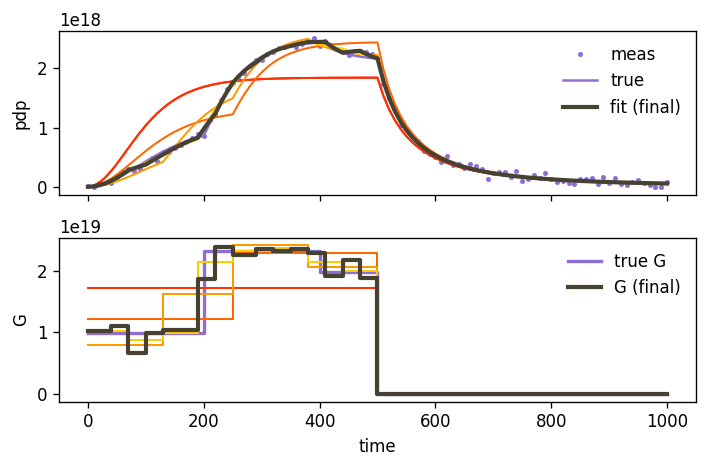

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# --- fixed curves (unchanged) ---
ax1.plot(t_meas, pdp_meas, "o", color="#8f6ed4", ms=2, label="meas")
ax1.plot(t_true, pdp_true, "-", color="#8f6ed4", label="true")
ax2.step(t_true, G_true, where="post", lw=2, color="#8f6ed4", label="true G")

# --- colormap setup ---
n_hist = len(zoom["history"])
cmap = plt.get_cmap("autumn")
norm = mcolors.Normalize(vmin=0, vmax=n_hist - 1)


# --- evolution across zoom levels ---
for k, h in enumerate(zoom["history"]):
    color = cmap(norm(k))
    ax1.plot(
        h["t_model"], h["pdp_hat"],
        "-", lw=1.2, color=color
    )
    ax2.step(
        h["t_model"], h["G_hat"],
        where="post", lw=1.2, color=color
    )

# --- final fit highlight ---
ax1.plot(
    fit["t_model"], fit["pdp_hat"],
    "-", lw=2.5, color="#454231", label="fit (final)"
)
ax2.step(
    fit["t_model"], fit["G_hat"],
    where="post", lw=2.5, color="#454231", label="G (final)"
)

ax1.set_ylabel("pdp")
ax1.legend(frameon=False)

ax2.set_ylabel("G")
ax2.set_xlabel("time")
ax2.legend(frameon=False)

plt.tight_layout()
plt.show()


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

active_color = "#b24a3a"
history_color = "0.7"

frames_dir = Path("frames")
frames_dir.mkdir(exist_ok=True)

hist = zoom["history"]

t_all = np.concatenate([h["t_model"] for h in hist] + [fit["t_model"]])
pdp_all = np.concatenate([h["pdp_hat"] for h in hist] + [fit["pdp_hat"], pdp_meas, pdp_true])
G_all = np.concatenate([h["G_hat"] for h in hist] + [fit["G_hat"]])

tlim = (t_all.min(), t_all.max())
pdp_pad = 0.05 * (pdp_all.max() - pdp_all.min())
G_pad = 0.05 * (G_all.max() - G_all.min())

pdplim = (pdp_all.min() - pdp_pad, pdp_all.max() + pdp_pad)
Glim = (G_all.min() - G_pad, G_all.max() + G_pad)

for k in range(len(hist)):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.plot(t_meas, pdp_meas, "o", ms=2, color="#8f6ed4")
    ax1.plot(t_true, pdp_true, "-", color="#8f6ed4")
    ax2.step(t_true, G_true, where="post", lw=1.5, color="#8f6ed4", label="true G")

    for j in range(k):
        h = hist[j]
        ax1.plot(h["t_model"], h["pdp_hat"], lw=0.8, color=history_color)
        ax2.step(h["t_model"], h["G_hat"], where="post", lw=0.8, color=history_color)

    h = hist[k]
    ax1.plot(h["t_model"], h["pdp_hat"], lw=2.0, color=active_color)
    ax2.step(h["t_model"], h["G_hat"], where="post", lw=2.0, color=active_color)

    ax1.set_xlim(tlim)
    ax1.set_ylim(pdplim)
    ax2.set_ylim(Glim)

    ax1.set_ylabel("pdp")
    ax2.set_ylabel("G")
    ax2.set_xlabel("time")

    plt.tight_layout()
    plt.savefig(frames_dir / f"frame_{k:03d}.png", dpi=150)
    plt.close(fig)